In [1]:
!pip install datasets scikit-learn pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is in

In [2]:
# Load Dataset
from datasets import load_dataset
dataset = load_dataset("tattabio/ec_classification")
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()
sample_size = min(2000, len(train_df))
train_df = train_df.sample(sample_size, random_state=42).reset_index(drop=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/285k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/87.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/512 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

In [ ]:
# Before this I tried two other things.

# One- hot encoding

# import numpy as np
# AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
# AA_TO_IDX = {aa: idx for idx, aa in enumerate(AMINO_ACIDS)}
# SEQ_LEN = 128
# def one_hot_encode(seq, max_len=SEQ_LEN):
#     encoded = np.zeros((max_len, 20), dtype=np.float32)
#     for i, aa in enumerate(seq[:max_len]):
#         if aa in AA_TO_IDX:
#             encoded[i, AA_TO_IDX[aa]] = 1.0
#     return encoded.flatten()
# X_train = np.stack(train_df['Sequence'].apply(one_hot_encode))
# X_test = np.stack(test_df['Sequence'].apply(one_hot_encode))

# For this I have taken C=1 as default, and seen that I got 0.0312 as Test accuracy and 0.0234 as F1 score.

# Normal k-mer grid search

# from sklearn.feature_extraction.text import CountVectorizer
# # Convert sequences to space-separated 3-mers
# def extract_kmers(sequence, k=3):
#     return ' '.join([sequence[i:i+k] for i in range(len(sequence)-k+1)])
# train_kmers = train_df['Sequence'].apply(lambda x: extract_kmers(x))
# test_kmers = test_df['Sequence'].apply(lambda x: extract_kmers(x))
# vectorizer = CountVectorizer()
# X_train = vectorizer.fit_transform(train_kmers)
# X_test = vectorizer.transform(test_kmers)

# For this part, I used GridSearchCV to find the best C
# For this I got best C as 0.1, and seen that I got 0.2109 as Test accuracy and 0.1651 as F1 score.


In [3]:
# TF-IDF 3-mer Encoding
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_kmers(sequence, k=3):
    return ' '.join([sequence[i:i+k] for i in range(len(sequence)-k+1)])

train_kmers = train_df['Sequence'].apply(lambda x: extract_kmers(x))
test_kmers = test_df['Sequence'].apply(lambda x: extract_kmers(x))

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_kmers)
X_test = vectorizer.transform(test_kmers)


In [4]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

In [5]:
# Logistic Regression + GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
logreg = LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial')
grid = GridSearchCV(logreg, param_grid, scoring='f1_macro', cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best C: {grid.best_params_['C']}")
print(f"Best CV F1 Score: {grid.best_score_:.4f}")

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best C: 10
Best CV F1 Score: 0.1289


In [6]:
# Evaluation
from sklearn.metrics import accuracy_score, f1_score

test_acc = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

y_train_pred = best_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='macro')
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")

Test Accuracy: 0.2500
Test F1 Score: 0.2229
Train Accuracy: 1.0000
Train F1 Score: 1.0000


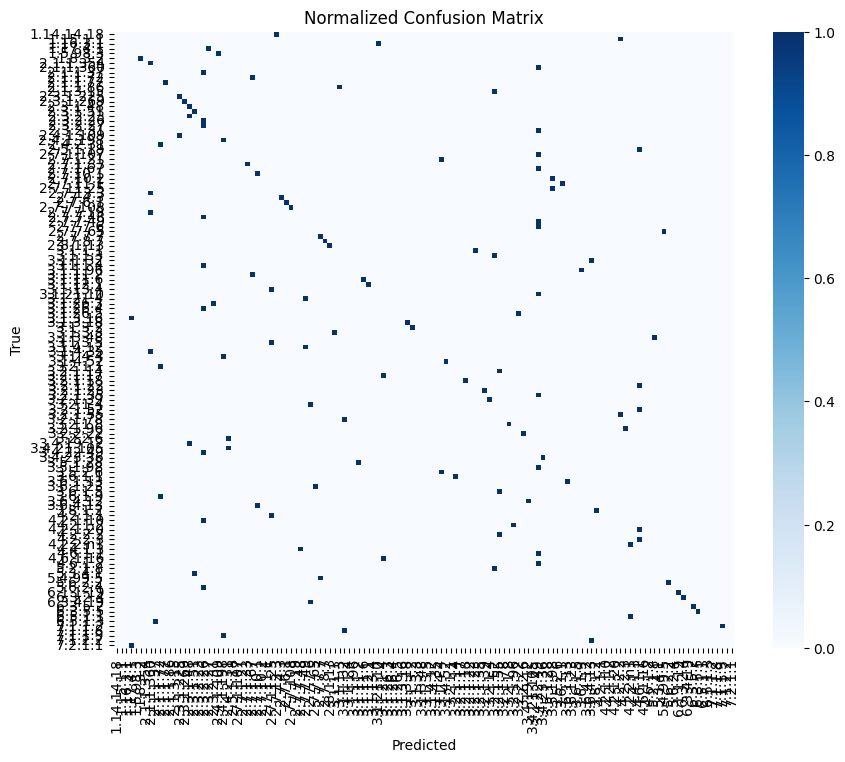

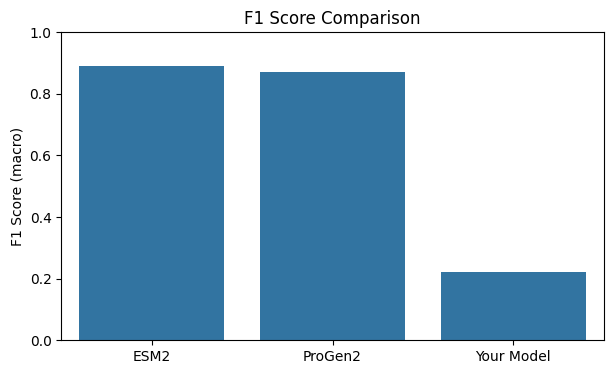

In [7]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

dgeb_scores = {"ESM2": 0.89, "ProGen2": 0.87, "Your Model": test_f1}
plt.figure(figsize=(7, 4))
sns.barplot(x=list(dgeb_scores.keys()), y=list(dgeb_scores.values()))
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score (macro)")
plt.ylim(0, 1)
plt.show()
